# Simulation of Extended Scenes with Poke and HCIPy

We are interested, on occasion, in detection of sources that aren't just points (bye bye exoplanets!). One such feature of interest in high-contrast imaging (HCI) are debris disks. There are a variety of reasons for this that I am not terribly qualified to explain, but they can inform planetary system formation in a very cool way. We can detect them in scattered light, which imparts a relatively significant linear polarization signature on the light.

To simulate a debris disks, we first consider our propagation operator $\mathbf{\mathcal{P}}$ which represents our forward model though our coronagraph, which interacts with a few complex masks.

$$\mathcal{P} = \mathcal{F}[\mathcal{F}[\mathcal{F}[\mathcal{F}[U_{o}] \times \mathbf{A}_{ep}] \times \mathbf{A}_{FPM}]\times \mathbf{A}_{LS}]$$

Our propagation operator is the Fourier transform, represented by $\mathcal{F}$. These operations are linear, so we can make use of a couple of theorems to make our simulation easier. The first is the convolution identity of the fourier transform. We know that a convolution is represented by a multiplication in the fourier domain.

$$A * B = \mathcal{F}^{-1} [\mathcal{F}[A] \mathcal{F}[B]]$$

Since the object (a disk) is conjugate to the image plane, we know that the relation between them is equal to the convolution of the object with the forward model's $\mathcal{P}$ point-response function.

$$\sum_{\theta_{x},\theta_{y}} PRF_{\theta_{x},\theta_{y}}$$

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import plots

In [12]:
pth = 'HR4796A/'
I = fits.getdata(pth+'I_HR4796A.fits')
Q = fits.getdata(pth+'Q_HR4796A.fits')
U = fits.getdata(pth+'U_HR4796A.fits')
V = fits.getdata(pth+'V_HR4796A.fits')

# crop out the middle
center = int(I.shape[0] / 2)
cut = int(150/2)

I = I[center-cut:center+cut,center-cut:center+cut]
Q = Q[center-cut:center+cut,center-cut:center+cut]
U = U[center-cut:center+cut,center-cut:center+cut]
V = V[center-cut:center+cut,center-cut:center+cut]


stokes_orig = [I,Q,U,V]

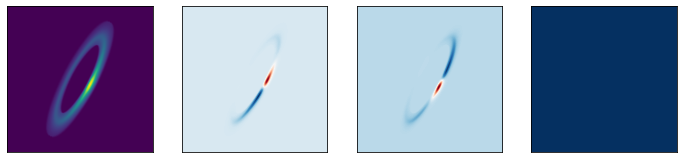

In [13]:
def plot_stokes(I, Q, U, V, power_scale=1/3):

    data = [I, Q, U, V]

    fig, axs = plt.subplots(figsize=[12,3], ncols=4)

    for i, (ax, im) in enumerate(zip(axs, data)):

        if i == 0:
            ax.imshow(im**power_scale)
        else:
            ax.imshow(im, cmap='RdBu_r')
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])

    plt.show()

plot_stokes(I, Q, U, V)

In [4]:
# assemble the forward model w/o segment variations
# from hcipy import *

# aperture = make_magellan_aperture(True)

# def forward_model(tiltsx,tiltsy,aperture,pupil_pix,focal_q,n_airy,order=4):
#     """generate grid of PSFs, nyquist sampling the focal plane

#     Parameters
#     ----------
#     tilts : numpy.ndarray
#         array of PSF locations to simulate, units of L/D
#     """

#      # assemble the grids
#     pupil_grid = make_pupil_grid(pupil_pix)
#     focal_grid = make_focal_grid(focal_q,n_airy)

#     print('focal grid shape = ',focal_grid.shape)

#     focal_pix = focal_grid.shape[0]

#     # set up a propagator
#     prop = FraunhoferPropagator(pupil_grid,focal_grid)

#     # set up the coronagraph
#     eval_aperture = aperture(pupil_grid)
#     coro = PerfectCoronagraph(eval_aperture,order)

#     psf_grid = np.zeros([*tiltsx.shape,focal_pix,focal_pix])
    
#     for i in range(tiltsx.shape[0]):
#         for j in range(tiltsx.shape[1]):

#             # create tilt wavefront
#             tilt = np.exp(1j * 2 * np.pi * (pupil_grid.x * tiltsx[i,j] + pupil_grid.y * tiltsy[i,j]))

#             # compute the PSF
#             psf = prop(coro.forward(Wavefront(eval_aperture*tilt)))
#             psf_grid[i,j] = psf.intensity.shaped

#     return psf_grid


In [14]:
# Assemble forward model with segment variations
import gsmt
from gsmt import (
    sim_params,
    filters,
    tmt_conf,
    elt_conf,
    gmt_conf,
    sim_gsmt_jones_pupil,
    create_elt_aperture_and_phase,
    create_tmt_aperture_and_phase
)
from hcipy import *
from importlib import reload

<ipython-input-24-3a68d0a1c441>:5: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(shift_psf))


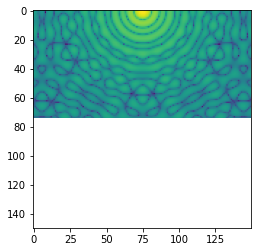

In [24]:
from scipy.ndimage import shift

loadedpsf = np.abs(np.load('nominal_psfs/TMT_nocoro_Iband_segvar.npy').reshape([2,2,150,150])[0,0])
shift_psf = shift(loadedpsf, shift=[-75,0])
plt.imshow(np.log10(shift_psf))

In [29]:
# set up a middling case
o = 4
pct = 0.2
indx = -2
telescopes = ['ELT', 'GMT']
OS = 1/2 # 1/2 for nyquist

# config all the tilts you gotta do
fov = 15
tiltsx = np.arange(-fov,fov+OS,OS)
tiltsy = np.copy(tiltsx)
focal_pix = int(cut*2)
print(focal_pix)

Q = 5
nairy = 150

for telescope in telescopes:
    psf_grid = np.zeros([*tiltsx.shape,*tiltsy.shape,2,2,focal_pix,focal_pix], dtype=np.complex128)

    center_psf = np.load('nominal_psfs/'+telescope+'_nocoro_Iband_segvar.npy').reshape([2,2,150,150])

    for i, tx in enumerate(tiltsx):
        for j, ty in enumerate(tiltsy):

            # reload(gsmt)

            # from gsmt import sim_params, gmt_conf, tmt_conf, elt_conf

            # sim_params['wavelength'] = filters['I'] * 1e-6
            # sim_params['order'] = o
            # sim_params['npix_pupil'] = 1024
            # sim_params['segment variation'] = True
            # sim_params['random seed'] = 20240220

            # # parts that change v.s. telescope
            # if telescope == 'TMT':
            #     sim_params['poke.Rayfront'] = 'rayfronts/TMT.msgpack'
            #     tele_conf = tmt_conf
            #     tele_conf['aberration ptv'] = pct
            # elif telescope == 'ELT':
            #     sim_params['poke.Rayfront'] = 'rayfronts/ELT.msgpack'
            #     tele_conf = elt_conf
            #     tele_conf['aberration ptv'] = pct
            # elif telescope == 'GMT':
            #     sim_params['poke.Rayfront'] = 'rayfronts/GMT.msgpack'
            #     tele_conf = gmt_conf
            #     tele_conf['n'] = indx

            # psf_grid[i,j] = sim_gsmt_jones_pupil(sim_params, tele_conf=tele_conf, tilt=[tx, ty]).electric_field.shaped
            psf_grid[i, j] = shift(center_psf,[0, 0, tx*Q, ty*Q])

    np.save('psf_grids/'+telescope+f'_grid_{fov}LD_{len(tiltsx)}tilts_128focal_order4_20pct_2indx_real.npy', psf_grid.real)
    np.save('psf_grids/'+telescope+f'_grid_{fov}LD_{len(tiltsx)}tilts_128focal_order4_20pct_2indx_imag.npy', psf_grid.imag)

# np.save(f'psf_grids/{gsmt}_grid_12LD_150focal_{o}order.npy',psf_grid)
    

150


In [26]:
center_psf.shape

(2, 2, 150, 150)

In [27]:
psf_grid.shape

(61, 61, 2, 2, 150, 150)

In [16]:
psf_grid.shape

(61, 61, 2, 2, 150, 150)

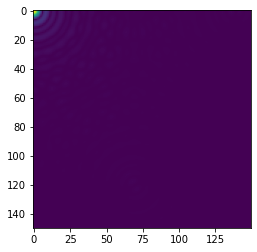

In [30]:
# np.save(f'psf_grids/tmt_grid_12LD_150focal_2order.npy',psf_grid)
psf_grid = np.load('psf_grids/TMT_grid_15LD_61tilts_150focal_order4_20pct_2indx_real.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'psf_grids/TMT_grid_15LD_61tilts_150focal_order4_20pct_2indx_real.npy'

In [9]:
def broadcast_kron(a,b):
    """broadcasted kronecker product of two N,M,...,2,2 arrays. Used for jones -> mueller conversion
    In the unbroadcasted case, this output looks like

    out = [a[0,0]*b,a[0,1]*b]
          [a[1,0]*b,a[1,1]*b]

    where out is a N,M,...,4,4 array. I wrote this to work for generally shaped kronecker products where the matrix
    is contained in the last two axes, but it's only tested for the Nx2x2 case

    Parameters
    ----------
    a : numpy.ndarray
        N,M,...,2,2 array used to scale b in kronecker product
    b : numpy.ndarray
        N,M,...,2,2 array used to form block matrices in kronecker product

    Returns
    -------
    out
        N,M,...,4,4 array
    """

    return np.einsum('...ik,...jl',a,b).reshape([*a.shape[:-2],int(a.shape[-2]*b.shape[-2]),int(a.shape[-1]*b.shape[-1])])

def jones_to_mueller(jones):
    """Construct a Mueller Matrix given a Jones Matrix. From Chipman, Lam, and Young Eq (6.99).

    Parameters
    ----------
    jones : ndarray with final dimensions 2x2
        The complex-valued jones matrices to convert into mueller matrices

    Returns
    -------
    M : np.ndarray
        Mueller matrix
    """

    U = np.array([[1,0,0,1],
                  [1,0,0,-1],
                  [0,1,1,0],
                  [0,1j,-1j,0]])/np.sqrt(2)
    
    if jones.ndim == 2:
        jprod = np.kron(np.conj(jones),jones)
    else:
        # broadcasted kronecker product with einsum
        jprod = broadcast_kron(np.conj(jones),jones)
    M = np.real(U @ jprod @ np.linalg.inv(U))

    return M

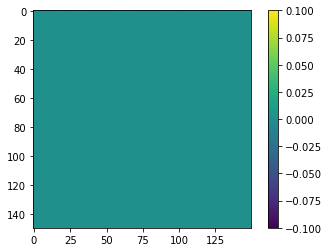

In [68]:
psf_grid.shape
plt.imshow(np.abs(psf_grid[0,0,0,0])**2)
plt.colorbar()
plt.show()

In [10]:
print(psf_grid.shape)

(97, 97, 2, 2, 150, 150)


In [15]:
psf_jones_matrix = np.moveaxis(np.moveaxis(psf_grid,-1,0),-1,0)
psf_jones_matrix.shape

(150, 150, 97, 97, 2, 2)

In [16]:
psf_mueller_matrix = np.zeros([*psf_jones_matrix.shape[:-2], 4, 4])

for i in range(psf_jones_matrix.shape[0]):
    for j in range(psf_jones_matrix.shape[1]):

        psf_mueller_matrix[i,j] = jones_to_mueller(psf_jones_matrix[i,j])

(150, 150, 97, 97, 4, 4)

In [57]:
S_conv = np.sum(np.sum(psf_mueller_matrix @ S,axis=2),axis=2)

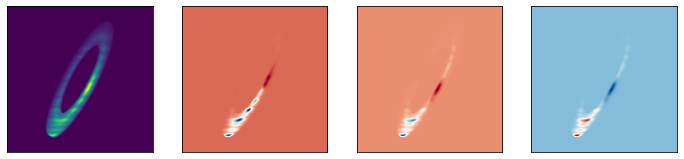

In [60]:
plot_stokes(S_conv[...,0,0],S_conv[...,1,0],S_conv[...,2,0],S_conv[...,3,0])

In [138]:
psf_matrix.nbytes * 1e-9

2.147483648

In [178]:
# Lets use double-difference PDI
pbs_angles = [0,np.pi/4,np.pi/2,3*np.pi/4]
single_differences = []
single_sums = []

# construct wavefront with disk


In [190]:
from importlib import reload
import instruments
reload(instruments)
from instruments import double_difference_stokes as pdi
Q,U = pdi(stokes)

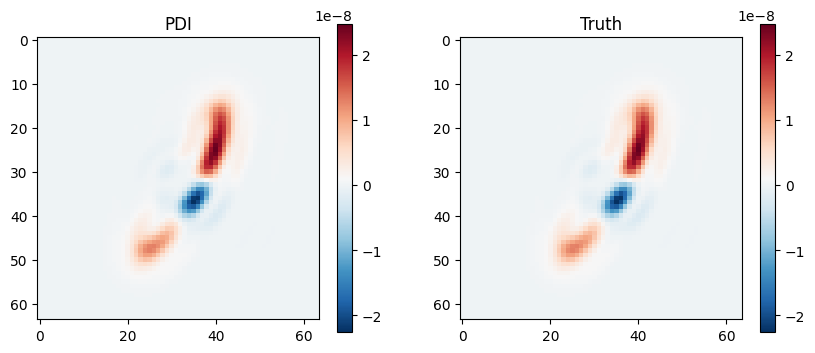

In [205]:
plt.figure(figsize=[10,4])
plt.subplot(121)
plt.title('PDI')
plt.imshow(U,cmap='RdBu_r')
plt.colorbar()
plt.subplot(122)
plt.title('Truth')
plt.imshow(-stokes[2],cmap='RdBu_r')
plt.colorbar()
plt.show()